In [1]:
import importlib
import inspect
import itertools
import logging
import matplotlib.pyplot as plt
import model_attributes as ma
import model_afolu as mafl
import model_ippu as mi
import model_circular_economy as mc
import model_electricity as ml
import model_energy as me
import model_socioeconomic as se
import setup_analysis as sa
import support_functions as sf
import numpy as np
import os, os.path
import pandas as pd
import pycountry
import re
import time
from typing import *
import warnings

warnings.filterwarnings("ignore")


/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/model_attributes.py:2244: UserWarning: Invalid subsector attribute 'key_varreqs_partial'. Valid return type values are:'pycategory_primary', 'abv_subsector', 'sector', 'abv_sector', 'key_varreqs_all'
  warnings.warn(f"Invalid subsector attribute '{return_type}'. Valid return type values are:{valid_rts}")


# Load general data
- The **ESSD dataset** gives some sector-level emissions that we cannot obtain elsewhere, notably chemicals and cement emissions
    - Minx, J. C., Lamb, W. F., Andrew, R. M., Canadell, J. G., Crippa, M., Döbbeling, N., Forster, P. M., Guizzardi, D., Olivier, J., Peters, G. P., Pongratz, J., Reisinger, A., Rigby, M., Saunois, M., Smith, S. J., Solazzo, E., and Tian, H.: A comprehensive and synthetic dataset for global, regional, and national greenhouse gas emissions by sector 1970–2018 with an extension to 2019, Earth Syst. Sci. Data, 13, 5213–5252, https://doi.org/10.5194/essd-13-5213-2021, 2021. 
    - Article is accessible at https://essd.copernicus.org/articles/13/5213/2021/)
    - The data itself (linked from above) can be accessed at https://zenodo.org/record/5566761#.ZBzAPC-B0bQ 
    - The data include mappings to IPCC emission codes, and it could be used as part of a two part calibration or aggregate calibration (IPPU + INEN at the same time)
- **climatewatchdata.org** historical data:
    - https://www.climatewatchdata.org/data-explorer/lts-content?lts-content-categories=All%20Selected&lts-content-indicators=All%20Selected&lts-content-locations=All%20Selected&lts-content-sectors=All%20Selected&page=1
    - "historical_emissions.csv"
    - ClimateWatch methodology, which includes map of subsectors to IPCC gas codes, can be found at https://wri-sites.s3.us-east-1.amazonaws.com/climatewatch.org/www.climatewatch.org/climate-watch/wri_metadata/CW_GHG_Method_Note.pdf
    

In [3]:
##  READ IN DATA

# get ESSD emission data
fp_essd_ghg_data = "/Users/jsyme/Documents/Projects/FY21/SWCHE131_1000/Data/Energy/essd_ghg_data.xlsx"
dict_essd = pd.read_excel(fp_essd_ghg_data, sheet_name = None);

# get climate watch data
df_climate_watch = pd.read_csv(
    "/Users/jsyme/Documents/Projects/FY21/SWCHE131_1000/Data/historical_emissions-2/historical_emissions.csv"
)

# set data and set some fields
df_essd = dict_essd.get("data").copy()

# set repository directory for SISEPUEDE Data
dir_repo_data = "/Users/jsyme/Documents/Projects/git_jbus/sisepuede_data"

# set some shared fields
field_country = "country"
field_description = "description"
field_emission_co2e = "emission_mt_co2e"
field_gas = "gas"
field_gas_cw = "gas_climatewatch"
field_ipcc = "IPCC_2006"
field_iso = "ISO"
field_iso3 = "iso_code3"
field_location_code = "location_code"
field_product_code = "product_code"
field_quantity = "quantity"
field_quantity_unit = "quantity_unit"
field_sector_cw = "sector"
field_title_sector = "sector_title"
field_title_subsector = "subsector_title"
field_value = "value"
field_value_thousand_usd = "value_m_usd"
field_year = "year"



##  INITIALIZE SISEPUEDE COMPONENTS--ATTRIBUTES AND MODELS--FOR VAR ACCESS

attr_gas = sa.model_attributes.dict_attributes.get("emission_gas")
attr_ind = sa.model_attributes.dict_attributes.get("cat_industry")
attr_region = sa.model_attributes.dict_attributes.get("region")
attr_time_period = sa.model_attributes.dict_attributes.get(f"dim_{sa.model_attributes.dim_time_period}")

model_energy = me.NonElectricEnergy(sa.model_attributes)
model_ippu = mi.IPPU(sa.model_attributes)



##############################
#   SOME DATA REPLACEMENTS   #
##############################


# in ESSD, drop mistake where CH4 shows up twice—remove invalid specification of 100-yr GWP
df_essd = df_essd[
    ~(
        df_essd[field_gas].isin(["CH4"]) &
        df_essd["gwp100_ar5"].isin([30])
    )
].reset_index(drop = True)


##  MAP GASSES TO THOSE DEFINED IN SISEPUEDE

gwp = 100
dict_gas_to_gwp = attr_gas.field_maps.get(f"{attr_gas.key}_to_global_warming_potential_{gwp}")
dict_gasname_to_gas = attr_gas.field_maps.get(f"gas_to_{attr_gas.key}")
field_gwp_sisepuede = f"gwp_{gwp}_sisepuede"

# replace gasses that have different conventions for the same name
dict_repl = {
    "HFC-43-10-mee": "HFC-43-10mee",
    "c-C4F8": "cc4f8"
}
df_essd[field_gas].replace(dict_repl, inplace = True)

# get all gasses available in ESSD data, then map to SISEPUEDE GWP
all_data_gasses = sorted(list(df_essd["gas"].unique()))
str_drop = "DROP"
dict_repl_gasses = {}
for gas in all_data_gasses:
    if gas.lower() in attr_gas.key_values:
        dict_repl_gasses.update({gas: gas.lower()})
    elif gas in dict_gasname_to_gas.keys():
        dict_repl_gasses.update({gas: dict_gasname_to_gas.get(gas)})
    else:
        dict_repl_gasses.update({gas: str_drop})
df_essd[field_gas].replace(dict_repl_gasses, inplace = True)
df_essd[field_gwp_sisepuede] = df_essd[field_gas].replace(dict_gas_to_gwp)

# add in map to climate watch classifications 
dict_gas_to_cw_gas = {"co2": "CO2", "ch4": "CH4", "n2o": "N2O", "sf6": "F-Gas"}
dict_gas_to_cw_gas.update(
    dict((x, "F-Gas") for x in list(set(df_essd[field_gas])) if x not in dict_gas_to_cw_gas.keys())
)
df_essd[field_gas_cw] = df_essd[field_gas].replace(dict_gas_to_cw_gas)

# add in aggregate CO2e using SISEPUEDE 100yr GWPs
vec_emit = np.array(df_essd[field_value])*np.array(df_essd[field_gwp_sisepuede])
vec_emit *= sa.model_attributes.get_mass_equivalent("tonne", "mt")
df_essd[field_emission_co2e] = vec_emit



##  CLEAN AND RESHAPE CLIMATE WATCH DATA

df_climate_watch.drop(["Data source", "Unit"], axis = 1, inplace = True)
df_climate_watch = pd.melt(
    df_climate_watch,
    id_vars = ["Country", "Sector", "Gas"], 
).rename(
    columns = {
        "Country": field_country,
        "Sector": field_sector_cw ,
        "Gas": field_gas_cw,
        "variable": field_year
    }
)

# clean countries
dict_repl_countries_manual = {
    "CÃ´te d'Ivoire": "Ivoire",
    "Democratic Republic of the Congo": "Congo, The Democratic Republic of the",
    "Republic of Congo": "Republic of the Congo",
    "Cape Verde": "Cabo Verde",
    "Laos": "Lao"
}
countries_drop = ["World", "European Union (27)"]
df_climate_watch[field_country].replace(dict_repl_countries_manual, inplace = True)
df_climate_watch = df_climate_watch[
    ~df_climate_watch[field_country].isin(countries_drop) &
    ~df_climate_watch[field_gas_cw].isin(["All GHG"])
].reset_index(drop = True)

print("getting ISO codes for ClimateWatch...")
# 
# try building crosswalk
#

def get_country_isos(
    df_in: pd.DataFrame,
    field_country: str,
    field_iso: str
) -> Tuple[pd.DataFrame, List[str], List[str], Dict]:
    
    """
    Use pycountry to get ISO codes for countries. 
    
    Returns a tuple of the form
    
        (df_in, countries, countries_failed, dict_countries_succes)
        
    """
    
    if not set([field_country]).issubset(set(df_in.columns)):
        return df_in
    
    countries = list(df_in[field_country].unique())
    dict_countries_succes = {}
    dict_countries_to_iso = {}

    countries_failed = []
    
    for country in countries:
        try:
            obj = pycountry.countries.search_fuzzy(country)
            dict_countries_succes.update({country: obj})
            dict_countries_to_iso.update({country: obj[0].alpha_3})

        except:
            countries_failed.append(country)

    if len(dict_countries_to_iso) > 0:
        df_in[field_iso] = df_in[field_country].replace(dict_countries_to_iso)
    
    return (df_in, countries, countries_failed, dict_countries_succes)



df_climate_watch, countries, countries_failed, dict_countries_succes = get_country_isos(
    df_climate_watch,
    field_country,
    field_iso3
)
  
print("Done.")
        
# convert to dictionary
df_cw_grouped = df_climate_watch.groupby([field_sector_cw])
dict_df_cw_by_sector = {}
for i, df in df_cw_grouped:
    dict_df_cw_by_sector.update({i: df})
del df_cw_grouped



####################################
#    BUILD SOME SHARED DATASETS    #
####################################

# build aggregate data from ESSD to generate residual comparison for calibration
#     NOTE: emission values from ESSD are in TONNE ORIGINAL GAS and had to be converted to 100yr GWP separately
df_essd_subsector_agg_compare_to_cw = sf.simple_df_agg(
    df_essd[[field_iso, field_title_subsector, field_year, field_gas_cw, field_emission_co2e]],
    [field_iso, field_year, field_title_subsector, field_gas_cw],
    {field_emission_co2e: "sum"}
)





getting ISO codes for ClimateWatch...
Done.


# CONSTRUCT KEY SHARED DATASETS
- Production and GDP
- Used in emission factors and elasticity estimates


In [5]:
# GET PRODUCTION

def read_inputs_from_repository(
    dict_modvars: Dict[str, Union[List[str], None]],
    fields_drop: Union[List[str], None] = ["nation"],
    fields_index: Union[List[str], None] = [field_iso3, field_year]
) -> pd.DataFrame: 
    """
    Read inputs from the repository for use.
    
    Function Arguements
    -------------------
    dict_modvars: dictionary with model variables as keys and a list of 
        categories to apply to (or None to read all applicable)
    fields_drop: fields to drop from input files (always lower case)
    fields_index: ORDERED fields to use for sorting (always lower case)
    """
    
    # some needed dictionaries
    dict_subsec_to_subdir = {
        "Energy": "Energy",
        "IPPU": "IPPU", 
        "Socioeconomic": "SocioEconomic"
    }
    dict_subsec_abv_to_sector = sa.model_attributes.dict_attributes.get("abbreviation_subsector").field_maps.get("abbreviation_subsector_to_sector")
    dict_subsec_to_subsec_abv = sa.model_attributes.dict_attributes.get("abbreviation_subsector").field_maps.get("subsector_to_abbreviation_subsector")

    
    
    # initialize output
    df_out = None
    dict_modvar_to_fields = {}
    dict_modvar_to_ordered_cats = {}
    
    for modvar in dict_modvars.keys():
    
        cats_defined = sa.model_attributes.get_variable_categories(modvar)
        cats = dict_modvars.get(modvar)
        cats = cats_defined if (cats is None) else cats
        cats = (
            [x for x in cats_defined if x in cats]
            if (cats_defined is not None)
            else [None]
        )

        subsec = sa.model_attributes.get_variable_subsector(modvar)
        sector = dict_subsec_abv_to_sector.get(
            dict_subsec_to_subsec_abv.get(subsec)
        )
        sector_repo = dict_subsec_to_subdir.get(sector)
        
        
        if (sector_repo is not None) and (len(cats) > 0):

            for cat in cats:
                
                restriction = None if (cat is None) else [cat]
                
                var_name = sa.model_attributes.build_varlist(
                    subsec,
                    modvar, 
                    restrict_to_category_values = restriction
                )[0]

                df_var = []
                
                for subdir in ["historical", "projected"]:
                    
                    fp_read = os.path.join(
                        dir_repo_data, 
                        sector_repo, 
                        var_name,
                        "input_to_sisepuede",
                        subdir, 
                        f"{var_name}.csv"
                    )
                        
                    try:
                        # read
                        df_var_cur = pd.read_csv(fp_read)
                        
                        # rename
                        df_var_cur.rename(
                            columns = {field_location_code: field_iso3},
                            inplace = True
                        ) if (field_location_code in df_var_cur.columns) else None
                        
                        dict_rnm = dict((x, x.lower()) for x in df_var_cur.columns)
                        df_var_cur.rename(
                            columns = dict_rnm,
                            inplace = True
                        )
                        
                        # drop any unwanted columns
                        df_var_cur.drop(
                            ["nation"], 
                            axis = 1,
                            inplace = True
                        ) if ("nation" in df_var_cur.columns) else None
                        
                        df_var.append(df_var_cur)
                        
                    except Exception as e:
                        warnings.warn(f"Error trying to read {fp_read}: {e}")
                
                # concatenate and sort
                df_var = pd.concat(df_var, axis = 0) if (len(df_var) > 0) else None
                if ((fields_index is not None) and (df_var is not None)):
                    fields_add = sorted([x for x in df_var.columns if x not in fields_index])
                    fields_exist = dict_modvar_to_fields.get(modvar)
                    (
                        dict_modvar_to_fields.update({modvar: fields_add}) 
                        if fields_exist is None
                        else dict_modvar_to_fields[modvar].extend(fields_add)
                    )
                    
                    (
                        dict_modvar_to_ordered_cats.update({modvar: [cat]}) 
                        if fields_exist is None
                        else dict_modvar_to_ordered_cats[modvar].append(cat)
                    )
                    
                    
                    
 
                if df_var is not None:
                    df_out = (
                        df_var
                        if (df_out is None)
                        else pd.merge(df_out, df_var)
                    )
    
    df_out.sort_values(by = fields_index, inplace = True) if (fields_index is not None) else None
            
    return df_out, dict_modvar_to_fields, dict_modvar_to_ordered_cats


# variables to read in (key) by categories (value)
dict_modvars = {
    model_ippu.modvar_ippu_prod_qty_init: None,
    model_ippu.model_socioeconomic.modvar_econ_gdp: None
}

var_units = sa.model_attributes.get_variable_characteristic(
    model_ippu.modvar_ippu_prod_qty_init,
    sa.model_attributes.varchar_str_unit_mass
)

df_inputs, dict_modvars_to_fields, dict_modvar_to_ordered_cats = read_inputs_from_repository(dict_modvars)



# Calculate Average Industrial Production Elasticities




- Get historical elasticities to GDP and use as direct inputs to SISEPUEDE (used to replicate historical emissions)
- Use data from historical period to estimate elasticity of production to GDP
    - bound using `elast_bounds` variable (see below)
    - apply this elasticity at the _second_ projection time period following the historical, and drift to 1 by final time period (elast = 1 is proportional growth with GDP)
    - for first projection time period, use a regression over historical time periods to estimate point (also bounded at +/- some proportion `max_dev_from_mean`)


In [326]:
years_historical = [x for x in list(df_inputs[field_year].unique()) if (x < 2020)]
# add another projected historical year to avoid odd growth behavior
years_historical_with_proj = years_historical + [max(years_historical)]
year_target = max(attr_time_period.table["year"])

# get some fields
field_gdp = dict_modvars_to_fields.get(model_ippu.model_socioeconomic.modvar_econ_gdp)[0]
fields_prod = dict_modvars_to_fields.get(model_ippu.modvar_ippu_prod_qty_init)

# production categories and elasticity fields
cats_all_prod = sa.model_attributes.get_variable_categories(model_ippu.modvar_ippu_prod_qty_init)
cats_prod = [
    x for x in cats_all_prod
    if sa.model_attributes.build_varlist(
        sa.model_attributes.subsec_name_ippu,
        model_ippu.modvar_ippu_prod_qty_init,
        restrict_to_category_values = [x]
    )[0] in fields_prod
]

fields_elast = sa.model_attributes.build_varlist(
    sa.model_attributes.subsec_name_ippu,
    model_ippu.modvar_ippu_elast_ind_prod_to_gdp,
    restrict_to_category_values = cats_prod
)


elasticity_default = 1.0

df_inputs_by_iso = df_inputs[df_inputs[field_iso3].isin(["BRA"])].groupby([field_iso3])
df_inputs_by_iso = df_inputs.groupby([field_iso3])


# define a function to project the first period post-historical (avoids setting volatile production to 0)
def project_from_array(
    arr_prod: np.ndarray,
    max_deviation_from_mean: float = 0.2
) -> np.ndarray:
    """
    Use a regression to project next production value + apply
        bounds to maximum deviation.
    """
    
    n, m = arr_prod.shape
    x = np.array([range(n), np.ones(n)]).transpose()
    xtx_inv = np.linalg.inv(np.dot(x.transpose(), x))
    
    vec_inputs_proj = np.array([[n + 1 , 1]])
    vec_outpus_proj_by_class = np.zeros(m)
                               
    for i in range(m):       
                               
        y = np.array([arr_prod[:, i]]).transpose()
        y_bar = np.mean(y)
        bounds = ((1 - max_deviation_from_mean)*y_bar, (1 + max_deviation_from_mean)*y_bar)
        
        xty = np.dot(x.transpose(), y)
        coeffs = np.dot(xtx_inv, xty)

        # revert to mean if any issues with NaNs show up
        val = np.dot(vec_inputs_proj, coeffs)[0, 0]
        val = y_bar if np.isnan(val) else val
        
        vec_outpus_proj_by_class[i] = float(sf.vec_bounds(val, bounds))
        
    return vec_outpus_proj_by_class
    
    
    
# max deviation from historical mean for first production value post-historical
max_dev_from_mean = 0.2
# bound elasticities -- kind of arbitrary at the moment
elast_bounds = (-0.5, 2.0)

df_elasticities = []

for i, df in df_inputs_by_iso:
    
    # get historical, then add dummy year
    df_hist = df[df[field_year].isin(years_historical)].sort_values(by = [field_year]).reset_index(drop = True)
    df_years = pd.DataFrame({field_year: years_historical})
    df_hist = pd.merge(df_years, df_hist, how = "left")
    df_hist.interpolate(inplace = True)
    df_hist.dropna(inplace = True, how = "any")
    
    # get production array and and project first non-historical time period from regression
    arr_prod = np.array(df_hist[fields_prod])
    arr_prod_proj_first_post_historical = project_from_array(arr_prod, max_deviation_from_mean = max_dev_from_mean)
    
    # append projected (first time period post-historical) to df_hist
    df_hist_append = {
        field_year: [max(years_historical) + 1],
        field_iso3: [i]
    }
    df_hist_append.update(
        dict(
            (fields_prod[i], [arr_prod_proj_first_post_historical[i]]) 
            for i in range(len(fields_prod))
        )
    )
    df_hist = pd.concat([df_hist, pd.DataFrame(df_hist_append)], axis = 0).reset_index(drop = True)
    # overwrite gdp since the final value is missing
    df_hist = sf.match_df_to_target_df(
        df_hist.drop([field_gdp], axis = 1),
        df[[field_year, field_iso3, field_gdp]],
        fields_index = [field_year, field_iso3],
        overwrite_only = False
    )

    # get change in gdp
    vec_gdp = np.array(df_hist[field_gdp])
    vec_gdp_change = vec_gdp[1:]/vec_gdp[0:-1] - 1
    # update arr_prod, change in production, and esl
    arr_prod = np.array(df_hist[fields_prod])
    arr_prod_change = arr_prod[1:]/arr_prod[0:-1] - 1
    
    # get elasticity of production to gdp
    arr_elast = sf.do_array_mult(arr_prod_change, 1/vec_gdp_change)
    arr_elast = np.nan_to_num(arr_elast, 1.0, posinf = 1.0)
    df_elast = pd.DataFrame(arr_elast, columns = fields_elast)
    df_hist = pd.concat([df_hist, df_elast], axis = 1)
    df_hist = df_hist[df_hist[field_year].isin(years_historical)].reset_index(drop = True)
    
    vec_means = np.zeros(arr_elast.shape[1])
    vec_medians = np.zeros(arr_elast.shape[1])
    vec_targs = np.zeros(arr_elast.shape[1])
    
    for j in range(len(vec_means)):
        
        # drop extreme elasticities and get mean/median--also, drop elasticity associated with the projection
        vec_cur = arr_elast[0:-1, j]
        vec_cur = vec_cur[np.where((vec_cur > min(vec_cur)) & (vec_cur < max(vec_cur)))]
        mu = np.mean(vec_cur)
        med = np.median(vec_cur)
        
        # bound negative mean and median elasticities at low number
        vec_means[j] = float(sf.vec_bounds(mu, elast_bounds)) if not np.isnan(mu) else 1.0
        vec_medians[j] = float(sf.vec_bounds(med, elast_bounds)) if not np.isnan(med) else 1.0
        
        m0 = min(vec_cur) if (len(vec_cur) > 0) else 1.0
        m1 = max(vec_cur) if (len(vec_cur) > 0) else 1.0
        
        if m0 > 0:
            vec_targs[j] = 1.0 if (mu > 1) else mu
        elif m1 < 0:
            vec_targs[j] = -1.0 if (mu < -1) else mu
        else:
            vec_targs[j] = elasticity_default
            
            
    
    ##  BUILD DATA FRAME FOR FUTURE YEARS
    
    years_full = years_historical.copy()
    years_full += list(range(max(years_historical) + 1, year_target + 1))
    df_years_full = pd.DataFrame({field_year: years_full})
    
    df_full = {field_year: [max(list(df_hist[field_year])) + 1, year_target], field_iso: [i, i]}
    df_full.update(dict((fields_elast[j], [vec_medians[j], vec_targs[j]]) for j in range(len(fields_elast))))
    df_full_check = df_full.copy()
    df_full = (
        pd.concat([df_hist, pd.DataFrame(df_full)], axis = 0)
        .dropna(subset = fields_elast)
        .drop([field_iso, field_gdp] + fields_prod, axis = 1)
    )
    
    df_full = (
        pd.merge(df_years_full, df_full, how = "left", on = [field_year])
        .interpolate()
        .sort_values(by = [field_year])
        .reset_index(drop = True)
    )
    
    df_full[field_iso3] = i
    df_elasticities.append(df_full)

df_elasticities = pd.concat(df_elasticities, axis = 0)


# WRITE ELASTICITIES TO CSV
df_elasticities.to_csv(
    sa.fp_csv_elasticity_of_industrial_production,
    index = None,
    encoding = "UTF-8"
)

In [ ]:
#######################
#    EXPORT IMAGES    #
#######################

dir_tmp = "/Users/jsyme/Desktop/figs_tmp"
os.makedirs(dir_tmp, exist_ok = True) if not os.path.exists(dir_tmp) else None

df = df_elasticities[df_elasticities[field_iso3].isin(["IND"])]

for cat in cats_prod:
    
    vec_years = np.array(df[field_year]).astype(int)
    
    vec_gdp = np.array(df[field_gdp])
    vec_gdp_change = vec_gdp[1:]/vec_gdp[0:-1] - 1
    vec_elast = np.array(df_full[f"elasticity_ippu_{cat}_production_to_gdp"])

    vec_prod_proj_edmundo = np.array(df[f"prodinit_ippu_{cat}_tonne"])
    prod_init = vec_prod_proj_edmundo[0]
    vec_prod = prod_init*sf.project_growth_scalar_from_elasticity(vec_gdp_change, vec_elast)

    fig, ax = plt.subplots(figsize = (10, 4))
    
    ax.set_ylim((0, max(vec_prod)*1.3))
    ax.set_title(f"Industrial Production of {cat}, Tonnes, {i}")
    ax.plot(vec_years, vec_prod, label = "new_projection", linewidth = 3, color = "steelblue")
    ax.plot(vec_years, vec_prod_proj_edmundo, label = "current_projection", linewidth = 2, color = "gray")
    ax.legend()
    
    plt.savefig(os.path.join(dir_tmp, f"prod_comparison_{cat}.jpg"), dpi = 100)


# CEMENT, CHEMICAL, AND METAL PRODUCTION EMISSION FACTORS
# &
# F-GAS TOTALS IN OTHER INDUSTRIES
- Load in production and gdp data from SISEPUEDE Data repository and use to estimate some factors


In [327]:
##  GENERATE ESSD CALIBRATION TARGETS

cat_fgas_cw = "F-Gas"
cw_sector_for_fgas_ippu = "Industrial Processes"

# build dictionary mapping ESSD industrial subsectors to SISEPUEDE industrial categories
dict_essd_sectors_to_sispuede_industries = {
    "Cement": ["cement"], 
    "Metals": ["metals"], 
    "Chemicals": ["chemicals"]
}
# add in residual industries
dict_essd_sectors_to_sispuede_industries.update(
    {
        "Other (industry)": [
            x for x in attr_ind.key_values 
            if x not in sum(list(dict_essd_sectors_to_sispuede_industries.values()), [])
        ]
    }
)
essd_sectors_for_fgas_ippu = sorted(list(dict_essd_sectors_to_sispuede_industries.keys()))


# generate ESSD data for industry (PPU and Energy in some cases)
df_essd_ind_wide = df_essd[
    df_essd[field_title_subsector].isin(essd_sectors_for_fgas_ippu)
][[field_iso, field_year, field_title_subsector, field_gas, field_emission_co2e]]

def st_gas_to_field(
    vec_input: np.ndarray
) -> str:
    """
    Convert a subsector title and gas to a field name for use in 
        calibration.
        
    Function Arguments
    ------------------
    - vec_input: input array with elements "subsector_title", "gas" (ordered)
    """
    subsector_title, gas = tuple(vec_input)
    
    st = sf.str_replace(
        subsector_title.lower(),
        {
            "(": "", ")": "", " ": "_"
        }
    )
    
    return f"emission_mt_co2e_essd_{st}_{gas.lower()}"

# specify field names, group, and interpolate
df_essd_ind_wide["field"] = df_essd_ind_wide[[field_title_subsector, field_gas]].apply(
    st_gas_to_field, 
    axis = 1,
    raw = True
)
df_essd_ind_wide_grouped = sf.pivot_df_clean(
    df_essd_ind_wide.drop([field_title_subsector, field_gas], axis = 1),
    ["field"],
    [field_emission_co2e]
)

df_essd_ind_wide_grouped = df_essd_ind_wide_grouped.groupby([field_iso])
df_essd_calibration_targets = []

for i, df in df_essd_ind_wide_grouped:
    df_essd_calibration_targets.append(df.interpolate().fillna(0.0))

df_essd_calibration_targets = pd.concat(df_essd_calibration_targets, axis = 0)

# finally, generate calibration dataframe
df_calibration_data = pd.merge(
    df_inputs,
    df_essd_calibration_targets.rename(columns = {field_iso: field_iso3}),
    on = [field_year, field_iso3]
).sort_values(by = [field_iso3, field_year]).reset_index(drop = True)

##  Calculate F-Gas residuals (ClimateWatch F-Gas - ESSD F-Gas) for use in calibration
- residuals represent fgasses unaccounted for in ESSD
- set residuals to $\max(CW - ESSD, 0)$ to avoid calibration problems due to estimation discrepancies

In [328]:
##
df_cw_ind = dict_df_cw_by_sector.get(cw_sector_for_fgas_ippu)
df_essd_ind_agg_to_cw = df_essd_subsector_agg_compare_to_cw[
    df_essd_subsector_agg_compare_to_cw[field_title_subsector].isin(essd_sectors_for_fgas_ippu)
]

# get FGas comparison
df_cw_ind_fgas = df_cw_ind[df_cw_ind[field_gas_cw].isin([cat_fgas_cw])]
df_essd_ind_fgas = df_essd_ind_agg_to_cw[
    df_essd_ind_agg_to_cw[field_gas_cw].isin([cat_fgas_cw])
].rename(columns = {field_iso: field_iso3})

# set temporary fields 
field_emission_co2e_cw = f"{field_emission_co2e}_cw"
field_emission_co2e_essd = f"{field_emission_co2e}_essd"
field_emission_co2e_residual = f"{field_emission_co2e}_residual"

# aggregate across sectors for comparison to climate watch
df_essd_ind_fgas_total = sf.simple_df_agg(
    df_essd_ind_fgas.drop([field_title_subsector], axis = 1),
    [field_iso3, field_year, field_gas_cw],
    {field_emission_co2e: "sum"}
).rename(columns = {field_emission_co2e: field_emission_co2e_essd})
# get CW equivalent
df_cw_ind_fgas_total = df_cw_ind_fgas[
    [field_iso3, field_year, field_gas_cw, field_value]
].rename(
    columns = {field_value: field_emission_co2e_cw}
).reset_index(drop = True)
df_cw_ind_fgas_total[field_year] = df_cw_ind_fgas_total[field_year].astype(int)

# plot
if False:
    fig, ax = plt.subplots(figsize = (15, 10))
    ax.set_ylim(0, 400)
    df_essd_ind_fgas_total[df_essd_ind_fgas_total[field_iso3].isin(["ARG"])][[field_emission_co2e_essd, field_year]].plot(x = field_year, ax = ax)

# finally, calculate totals and get residual (bounded below at 0)
df_ippu_fgas_totals_by_iso = pd.merge(
    df_essd_ind_fgas_total,
    df_cw_ind_fgas_total
).drop([field_gas_cw], axis = 1).dropna()

df_ippu_fgas_totals_by_iso[field_emission_co2e_residual] = sf.vec_bounds(
    np.array(df_ippu_fgas_totals_by_iso[field_emission_co2e_cw]) - np.array(df_ippu_fgas_totals_by_iso[field_emission_co2e_essd]),
    (0, np.inf)
)

#
# df_ippu_fgas_totals_by_iso gives total  
#  


In [379]:
importlib.reload(ma)
importlib.reload(sa)
importlib.reload(mi)
model_ippu = mi.IPPU(sa.model_attributes)

In [621]:

# start with gasses in ESSD data that can be accounted for
# map the output variable to different inputs based on [GDP, PROD]
dict_output_to_input_factors_for_essd_gasses = {
    model_ippu.modvar_ippu_emissions_process_dodecafluoropentane: [
        None,
        model_ippu.modvar_ippu_ef_dodecafluoropentane_per_prod_process
    ],
    model_ippu.modvar_ippu_emissions_process_nf3: [
        None,
        model_ippu.modvar_ippu_ef_nf3_per_prod_process
    ],
    model_ippu.modvar_ippu_emissions_process_sf6: [
        model_ippu.modvar_ippu_ef_sf6_per_gdp_process,
        model_ippu.modvar_ippu_ef_sf6_per_prod_process
    ],
    # process HFCs
    model_ippu.modvar_ippu_emissions_process_hfc23: [
        None,
        model_ippu.modvar_ippu_ef_hfc23_per_prod_process
    ],
    model_ippu.modvar_ippu_emissions_process_hfc32: [
        None,
        model_ippu.modvar_ippu_ef_hfc32_per_prod_process
    ],
    model_ippu.modvar_ippu_emissions_process_hfc41: [
        None,
        model_ippu.modvar_ippu_ef_hfc41_per_prod_process
    ],
    model_ippu.modvar_ippu_emissions_process_hfc125: [
        None,
        model_ippu.modvar_ippu_ef_hfc125_per_prod_process
    ],
    model_ippu.modvar_ippu_emissions_process_hfc134a: [
        None,
        model_ippu.modvar_ippu_ef_hfc134a_per_prod_process
    ],
    model_ippu.modvar_ippu_emissions_process_hfc143a: [
        None,
        model_ippu.modvar_ippu_ef_hfc143a_per_prod_process
    ],
    model_ippu.modvar_ippu_emissions_process_hfc152a: [
        None,
        model_ippu.modvar_ippu_ef_hfc152a_per_prod_process
    ],
    model_ippu.modvar_ippu_emissions_process_hfc227ea: [
        None,
        model_ippu.modvar_ippu_ef_hfc227ea_per_prod_process
    ],
    model_ippu.modvar_ippu_emissions_process_hfc365mfc: [
        None,
        model_ippu.modvar_ippu_ef_hfc365mfc_per_prod_process
    ],
    # process pfcs
    model_ippu.modvar_ippu_emissions_process_pfc14: [
        None,
        model_ippu.modvar_ippu_ef_pfc14_per_prod_process
    ],
    model_ippu.modvar_ippu_emissions_process_pfc116: [
        None,
        model_ippu.modvar_ippu_ef_pfc116_per_prod_process
    ],
    model_ippu.modvar_ippu_emissions_process_pfc218: [
        None,
        model_ippu.modvar_ippu_ef_pfc218_per_prod_process
    ],
    model_ippu.modvar_ippu_emissions_process_pfcc318: [
        None,
        model_ippu.modvar_ippu_ef_pfcc318_per_prod_process
    ],
    model_ippu.modvar_ippu_emissions_process_pfc1114: [
        None,
        model_ippu.modvar_ippu_ef_pfc1114_per_prod_process
    ],
    model_ippu.modvar_ippu_emissions_process_pfcc1418: [
        None,
        model_ippu.modvar_ippu_ef_pfcc1418_per_prod_process
    ],
    model_ippu.modvar_ippu_emissions_process_pfc3110: [
        None,
        model_ippu.modvar_ippu_ef_pfc3110_per_prod_process
    ],
    model_ippu.modvar_ippu_emissions_process_pfc5114: [
        None,
        model_ippu.modvar_ippu_ef_pfc5114_per_prod_process
    ],
    # product use HCFCs]
    model_ippu.modvar_ippu_emissions_produse_hcfc141b: [
        model_ippu.modvar_ippu_ef_hcfc141b_per_gdp_produse,
        None
    ],
    model_ippu.modvar_ippu_emissions_produse_hcfc142b: [
        model_ippu.modvar_ippu_ef_hcfc142b_per_gdp_produse,
        None
    ],
    # product use HFC
    model_ippu.modvar_ippu_emissions_produse_hfc23: [
        model_ippu.modvar_ippu_ef_hfc23_per_gdp_produse,
        None
    ],
    model_ippu.modvar_ippu_emissions_produse_hfc32: [
        model_ippu.modvar_ippu_ef_hfc32_per_gdp_produse,
        None
    ],
    model_ippu.modvar_ippu_emissions_produse_hfc125: [
        model_ippu.modvar_ippu_ef_hfc125_per_gdp_produse,
        None
    ],
    model_ippu.modvar_ippu_emissions_produse_hfc134: [
        model_ippu.modvar_ippu_ef_hfc134_per_gdp_produse,
        None
    ],
    model_ippu.modvar_ippu_emissions_produse_hfc134a: [
        model_ippu.modvar_ippu_ef_hfc134a_per_gdp_produse,
        None
    ],
    model_ippu.modvar_ippu_emissions_produse_hfc143: [
        model_ippu.modvar_ippu_ef_hfc143_per_gdp_produse,
        None
    ],
    model_ippu.modvar_ippu_emissions_produse_hfc143a: [
        model_ippu.modvar_ippu_ef_hfc143a_per_gdp_produse,
        None
    ],
    model_ippu.modvar_ippu_emissions_produse_hfc152a: [
        model_ippu.modvar_ippu_ef_hfc152a_per_gdp_produse,
        None
    ],
    model_ippu.modvar_ippu_emissions_produse_hfc227ea: [
        model_ippu.modvar_ippu_ef_hfc227ea_per_gdp_produse,
        None
    ],
    model_ippu.modvar_ippu_emissions_produse_hfc236fa: [
        model_ippu.modvar_ippu_ef_hfc236fa_per_gdp_produse,
        None
    ],
    model_ippu.modvar_ippu_emissions_produse_hfc245fa: [
        model_ippu.modvar_ippu_ef_hfc245fa_per_gdp_produse,
        None
    ],
    model_ippu.modvar_ippu_emissions_produse_hfc365mfc: [
        model_ippu.modvar_ippu_ef_hfc365mfc_per_gdp_produse,
        None
    ],
    model_ippu.modvar_ippu_emissions_produse_hfc4310mee: [
        model_ippu.modvar_ippu_ef_hfc4310mee_per_gdp_produse,
        None
    ],
    model_ippu.modvar_ippu_emissions_produse_pfc14: [
        model_ippu.modvar_ippu_ef_pfc14_per_gdp_produse,
        None
    ],
    model_ippu.modvar_ippu_emissions_produse_pfc116: [
        model_ippu.modvar_ippu_ef_pfc116_per_gdp_produse,
        None
    ],
    model_ippu.modvar_ippu_emissions_produse_pfc3110: [
        model_ippu.modvar_ippu_ef_pfc3110_per_gdp_produse,
        None
    ],
    model_ippu.modvar_ippu_emissions_produse_pfc5114: [
        model_ippu.modvar_ippu_ef_pfc5114_per_gdp_produse,
        None
    ]
       
}

# initialize other components
modvar_gdp = model_ippu.model_socioeconomic.modvar_econ_gdp
subsec_gdp = sa.model_attributes.get_variable_subsector(modvar_gdp)
field_gdp = sa.model_attributes.build_varlist(
    subsec_gdp,
    modvar_gdp
)[0]

# production characteristics
modvar_prod = model_ippu.modvar_ippu_prod_qty_init
subsec_prod = sa.model_attributes.get_variable_subsector(modvar_prod)
units_mass_per_prod = sa.model_attributes.get_variable_characteristic(
    modvar_prod,
    sa.model_attributes.varchar_str_unit_mass
)


df_efs_out = None
fields_targeted = []

for key, modvars in dict_output_to_input_factors_for_essd_gasses.items():
    
    # SISEPUEDE industrial categories associated with this output emission variable
    cats_in_output = sa.model_attributes.get_variable_categories(key)
    gas = sa.model_attributes.get_variable_characteristic(key, sa.model_attributes.varchar_str_emission_gas)
    gwp = sa.model_attributes.get_gwp(gas, 100)
    
    for essd_sector in dict_essd_sectors_to_sispuede_industries.keys():
        
        # get SISEPUEDE industrial categories associated with this ESSD sector and check if any are also included in this output variable
        cats_associated_with_essd_sector = dict_essd_sectors_to_sispuede_industries.get(essd_sector)
        essd_cats_in_output = sorted(list(set(cats_in_output) & set(cats_associated_with_essd_sector)))
        n_essd_cats_in_output = len(essd_cats_in_output)
        
        # calibration target to match in df_essd_calibration_targets
        field_calibration_target = st_gas_to_field(np.array([essd_sector, gas]))
        
        modvar_check = None
        
        if (n_essd_cats_in_output > 0) and (field_calibration_target in df_essd_calibration_targets.columns):
            
            fields_targeted.append(field_calibration_target)
            
            #print(f"{key} & {essd_sector}: {essd_cats_in_output}\n")
            
            # check GDP variable and cats
            modvar_ef_per_gdp = modvars[0]
            subsec_modvar_ef_per_gdp = sa.model_attributes.get_variable_subsector(modvar_ef_per_gdp) if (modvar_ef_per_gdp is not None) else None
            cats_modvar_ef_per_gdp = sa.model_attributes.get_variable_categories(modvar_ef_per_gdp) if (modvar_ef_per_gdp is not None) else None

            # check production variable and cats
            modvar_ef_per_prod = modvars[1]
            subsec_modvar_ef_per_prod = sa.model_attributes.get_variable_subsector(modvar_ef_per_prod) if (modvar_ef_per_prod is not None) else None
            cats_modvar_ef_per_prod = sa.model_attributes.get_variable_categories(modvar_ef_per_prod) if (modvar_ef_per_prod is not None) else None
            
            
            # loop over categories to determine if they are associated with GDP and/or Process emissions 
            for cat in essd_cats_in_output:
            
                # check if category is driven by GDP
                if (cats_modvar_ef_per_gdp is not None) and (cat in cats_modvar_ef_per_gdp):
                    
                    # set driver (gdp) and emission factor field (per gdp)
                    field_driver = field_gdp
                    field_ef = sa.model_attributes.build_varlist(
                        subsec_modvar_ef_per_gdp,
                        modvar_ef_per_gdp,
                        restrict_to_category_values = [cat]
                    )[0]
                    
                    # get mass units of ef
                    unit_mass = sa.model_attributes.get_variable_characteristic(
                        modvar_ef_per_gdp,
                        sa.model_attributes.varchar_str_unit_mass
                    )
                    
                    
                # check for production driver
                if (cats_modvar_ef_per_prod is not None) and (cat in cats_modvar_ef_per_prod):
    
                    # set driver (production) and emission factor field (per production)
                    field_driver = sa.model_attributes.build_varlist(
                        subsec_prod,
                        modvar_prod,
                        restrict_to_category_values = [cat]
                    )[0]
                    field_ef = sa.model_attributes.build_varlist(
                        subsec_modvar_ef_per_prod,
                        modvar_ef_per_prod,
                        restrict_to_category_values = [cat]
                    )[0]
                    
                    # get mass units of ef (per production is unitless, so defaults to production mass)
                    unit_mass = units_mass_per_prod
                    
                
                modvar_check = modvar_ef_per_prod if (modvar_ef_per_prod is not None) else modvar_check

                # get scalar to convert EF emissions to ESSD emissions mass
                denom = np.array(df_calibration_data[field_driver]) * sa.model_attributes.get_mass_equivalent(unit_mass, "mt")
                numer = np.array(df_calibration_data[field_calibration_target])/(n_essd_cats_in_output * gwp)
                vec_ef = numer/denom
                
                df_out = df_calibration_data[[field_iso3, field_year]].copy()
                df_out[field_ef] = vec_ef
                
                # add to data frame
                df_efs_out = (
                    df_out
                    if df_efs_out is None
                    else pd.merge(df_efs_out, df_out, how = "left")
                )

                
# WRITE EMISSION FACTORS TO CSV
df_efs_out.to_csv(
    sa.fp_csv_ippu_fc_efs,
    index = None,
    encoding = "UTF-8"
)               



# NEXT, BUILD CEMENT CLINKER NET IMPORTS AND USE DATA
- Data are taken from WorldBank WTI
    - CEMENT CLINKER NET IMPORTS (IMPORTS AND EXPORTS) HS6 = 252310
    - API VALUES USED (year: 2010-2021, tradeflow: Exports/Imports) MANUALLY DOWNLOADA
    - https://wits.worldbank.org/trade/comtrade/en/country/ALL/year/2021/tradeflow/Imports/partner/WLD/product/252310#


In [542]:
# location of excel files
dir_clinker_trade = "/Users/jsyme/Documents/Projects/FY21/SWCHE131_1000/Data/ippu/WITS_Clinker_Data"
regex_export = re.compile("WITS-By-HS6Product-(\d*)_exports.xlsx")
regex_import = re.compile("WITS-By-HS6Product-(\d*)_imports.xlsx")

# key model variable
modvar_net_imports_clinker = model_ippu.modvar_ippu_net_imports_clinker

# countries to replace before getting ISO3s
dict_replace_wti_countries = {
    "Egypt, Arab Rep.": "Egypt",
    "Korea, Rep.": "South Korea",
    "Occ.Pal.Terr": "Palestine",
    "European Union": None,
    "Other Asia, nes": "Taiwan",
    "Congo, Rep.": "Republic of the Congo",
    "Lao PDR": "Lao",
    "Serbia, FR(Serbia/Montenegro)": "Serbia",
    "Iran, Islamic Rep.": "Iran",
    "Fm Sudan": "Sudan",
    "Ethiopia(excludes Eritrea)": "Ethiopia",
    "Bahamas, The": "Bahamas"
}



##  DEFINE SOME FUNCTIONS

def build_wti_dataframe(
    dir_read: str, 
    regex: re.Pattern,
    fields_extract: Union[Dict[str, str], List[str], None] = None,
    sheet_name: str = "By-HS6Product"
) -> pd.DataFrame:
    """
    
    Function Arguments
    ------------------
    - dir_read: directory of input excel files
    - regex: regex to use to match excel files for read
    
    Keyword Arguments
    -----------------
    - fields_extract: fields to extract. 
        * If None, reads all
        * If a list of fields, reads only those fields in (if 
            available)
        * If a dictionary of fields, reads in fields specified as 
            keys and renames to values
    - sheet_name: sheet to use to extract WTI HS6 data
    """
    
    # some checks on files
    if not os.path.exists(dir_read):
        return None
    
    fns_read = [x for x in os.listdir(dir_read) if regex.match(x) is not None]
    if len(fns_read) == 0:
        return None
    
    # initialize output components
    
    df_out = []
    dict_rnm = None
    fields_out = None
    
    for fn in fns_read:
        
        df = pd.read_excel(
            os.path.join(dir_read, fn), 
            sheet_name = sheet_name
        )
        
        # initialize field information
        if len(df_out) == 0:
            
            if (fields_extract is None):
                fields_out = list(df.columns) 
            elif isinstance(fields_extract, list):
                fields_out = [x for x in df.columns if x in fields_extract]
            elif isinstance(fields_extract, dict):
                fields_out = [x for x in df.columns if x in fields_extract.keys()]
                dict_rnm = dict((k, v) for k, v in fields_extract.items() if k in fields_out)
        
        # rename if applicable
        df = df[fields_out]
        df.rename(columns = dict_rnm, inplace = True) if (dict_rnm is not None) else None
        df_out.append(df)
        
    
    df_out = pd.concat(df_out, axis = 0).reset_index(drop = True)
    
    return df_out



def clean_wti_df(
    df_in: pd.DataFrame,
    convert_units_and_drop_units_field: bool = True,
    dict_country_replace: Union[Dict[str, str], None] = None,
    field_country: Union[str, None] = None,
    field_iso: Union[str, None] = None,
    field_quantity: Union[str, None] = None,
    field_quantity_unit: Union[str, None] = None,
    model_attributes: ma.ModelAttributes = None,
    target_mass: Union[str, None] = None
) -> pd.DataFrame:
    """
    After reading in the WTI dataframe (`df_in`), apply cleanings here.
    
    
    Keyword Arguments
    -----------------
    - convert_units_and_drop_units_field: if True, will convert units in 
        the quantity to target mass and drop field_quantity units (if 
        `field_quantity` and `field_quantity_unit` both in the data frame)
    - dict_country_replace: dictionary mapping countries to new names
    - field_country: field used to identify countries
    - field_iso: field to use for specifying ISO code
    - field_quantity: field containing quantities associated with the 
        tradeflow (mass)
    - field_quantity_unit: units for quantity (mass)
    - target_mass: target mass units to convert quantities to
    """
    
    field_quant_valid = False
    field_quant_unit_valid = False
    unit = None
    
    # clean units
    if (field_quantity_unit is not None) and (field_quantity_unit in df_in.columns):
        
        # assume all units are the same
        unit = list(df_in[~df_in[field_quantity_unit].isna()][field_quantity_unit].unique())[0]
        df_in[field_quantity_unit].fillna(unit, inplace = True)
        df_in[field_quantity_unit].replace({unit: str(unit).lower()}, inplace = True)
        field_quant_valid = True
    
    # clean quantity
    if (field_quantity is not None) and (field_quantity in df_in.columns):
        
        df_in[field_quantity].fillna(0.0, inplace = True)
        field_quant_unit_valid = True
        
    # clean countries
    
    if (field_country is not None) and (field_country in df_in.columns):
        
        (
            df_in[field_country].replace(dict_country_replace, inplace = True)
            if field_country is not None
            else None
        )
        
        # add ISO
        df_in, countries, countries_failed, dict_countries = get_country_isos(
            df_in,
            field_country,
            field_iso
        )
        
        df_in = df_in[
            [x is not None for x in list(df_in[field_iso])]
        ].reset_index(drop = True)
        
    
    
    ##  CONVERT AND DROP UNITS?
    
    convert_and_drop = (target_mass is not None) and (model_attributes is not None)
    convert_and_drop = convert_and_drop & convert_units_and_drop_units_field & field_quant_valid & field_quant_unit_valid
    field_wti_quantity_with_unit = None
    scalar = None
    
    if convert_and_drop:
        try:
            scalar = model_attributes.get_mass_equivalent(unit, target_mass)
        except Exception as e:
            None
        
    if scalar is not None:
        df_in[field_quantity] = np.array(df_in[field_quantity])*scalar
        field_quantity_with_unit = f"{field_quantity}_{target_mass}"
        
        df_in.rename(columns = {field_quantity: field_quantity_with_unit}, inplace = True)
        df_in.drop([field_quantity_unit], axis = 1, inplace = True)
        
        
    return df_in, field_quantity_with_unit



##  run and clean

# set new quantity field
units_mass_ippu_clinker_net_imports = sa.model_attributes.get_variable_characteristic(
    modvar_net_imports_clinker,
    sa.model_attributes.varchar_str_unit_mass
)

fields_extract = {
    "Reporter": field_country, 
    "Year": field_year,
    "Trade Value 1000USD": field_value_thousand_usd,
    "Quantity": field_quantity,
    "Quantity Unit": field_quantity_unit
}


df_clinker_trade = None
dict_fields_quantity = {}

for build in ["import", "export"]:
    
    regex = regex_export if (build == "export") else regex_import

    df_wti = build_wti_dataframe(
        dir_clinker_trade, 
        regex,
        fields_extract = fields_extract
    ) 

    df_wti, field_quantity_cur_with_units = clean_wti_df(
        df_wti, 
        convert_units_and_drop_units_field = True,
        dict_country_replace = dict_replace_wti_countries,
        field_country = field_country,
        field_iso = field_iso3,
        field_quantity = field_quantity,
        field_quantity_unit = field_quantity_unit,
        model_attributes = sa.model_attributes,
        target_mass = units_mass_ippu_clinker_net_imports
    )
    
    field_quantity_build = field_quantity_cur_with_units.replace(field_quantity, build)
    dict_fields_quantity.update({build: field_quantity_build})
    
    
    df_wti.rename(
        columns = {
            field_quantity_cur_with_units: field_quantity_build
        },
        inplace = True
    )
    
    fields_ext = [field_iso3, field_year, field_quantity_build]
    
    df_clinker_trade = (
        df_wti[fields_ext]
        if df_clinker_trade is None
        else pd.merge(df_clinker_trade, df_wti[fields_ext], how = "outer", on = [field_year, field_iso3])
    )

# fill NAs and add difference
df_clinker_trade.fillna(0.0, inplace = True)
field_quantity_import = dict_fields_quantity.get("import")
field_quantity_export = dict_fields_quantity.get("export")
field_net_imports = sa.model_attributes.build_varlist(None, modvar_net_imports_clinker)[0]
df_clinker_trade[field_net_imports] = np.array(df_clinker_trade[field_quantity_import]) - np.array(df_clinker_trade[field_quantity_export])

# sort and 
df_clinker_trade = (
    df_clinker_trade
    .sort_values(by = [field_iso3, field_year])
    .reset_index(drop = True)
)
    




# BUILD CLNKER FACTOR
- Global average is assumed to be 0.72
    - https://www.iea.org/reports/cement
- LAC specific numbers are pulled from:
    - Villagrán-Zaccardi, Y.; Pareja, R.; Rojas, L.; Irassar, E. F.; Torres-Acosta, A.; Tobón, J.; John, V. M. Overview of Cement and Concrete Production in Latin America and the Caribbean With a Focus on the Goals of Reaching Carbon Neutrality. RILEM Tech Lett 2022, 7, 30-46.
    - https://doi.org/10.21809/rilemtechlett.2022.155
    - https://letters.rilem.net/index.php/rilem/article/view/155

In [628]:
field_clinker_fraction = sa.model_attributes.build_varlist(
    None,
    model_ippu.modvar_ippu_clinker_fraction_cement
)[0]
clinker_factor_default = 0.72

# from Villagrán et al. (2022) see Table 1.
dict_iso_to_clinker_factor = {
    "ARG": 0.68,
    "BOL": 0.7,
    "BRA": 0.685,
    "CHL": 0.7,
    "COL": 0.68,
    "ECU": 0.7,
    "MEX": 0.75,
    "PER": 0.77,
    "DOM": 0.73,
    "PAN": 0.72,
    "CRI": 0.72,
    "HND": 0.72,
    "GTM": 0.72
}

# build a dataframe that applies to all countries 
all_countries = sorted(list(set(df_inputs[field_iso3])))
all_years = sorted(list(df_inputs[field_year].unique()))
df_clinker_factor = pd.DataFrame(
    list(
        itertools.product(
            all_countries, 
            all_years
        )
    ), 
    columns = [field_iso3, field_year]
)

# add clinker fraction
df_clinker_factor[field_clinker_fraction] = df_clinker_factor[field_iso3].apply(
    dict_iso_to_clinker_factor.get,
    args = (clinker_factor_default, )
)

df_clinker_factor = (
    df_clinker_factor
    .sort_values(by = [field_iso3, field_year])
    .reset_index(drop = True)
)

df_clinker_factor.to_csv(
    sa.fp_csv_ippu_frac_cement_clinker,
    index = None,
    encoding = "UTF-8"
)



# GET CEMENT PRODUTION, CLINKER IMPORT FRACTIONS + EXPORTS

In [656]:
# set field
field_cement_prod = sa.model_attributes.build_varlist(
    None,
    model_ippu.modvar_ippu_prod_qty_init,
    restrict_to_category_values = ["cement"]
)[0]
field_clinker_production = "production_clinker_tonne"
field_cement_emission_essd = "emission_mt_co2e_essd_cement_co2"


# clinker import/exports, cement production
df_clinker_exports = df_clinker_trade[[field_year, field_iso3, field_quantity_export]].copy()
df_clinker_imports = df_clinker_trade[[field_year, field_iso3, field_quantity_import]].copy()
df_cement_prod = df_inputs[[field_year, field_iso3, field_cement_prod]].copy()

# get historical clinker demands
df_clinker_demands_hist = pd.merge(df_cement_prod, df_clinker_factor)
years_historical = [x for x in sorted(list(set(df_clinker_demands_hist[field_year]))) if x < 2020]
df_clinker_demands_hist = df_clinker_demands_hist[df_clinker_demands_hist[field_year].isin(years_historical)].reset_index(drop = True)

# get estimated clinker production
df_clinker_demands_hist[field_clinker_production] = np.array(df_clinker_demands_hist[field_cement_prod]) * np.array(df_clinker_demands_hist[field_clinker_fraction])



df_clinker_demands_hist2 = pd.merge(
    df_clinker_demands_hist,
    df_clinker_trade
)

df_clinker_demands_hist2 = pd.merge(
    df_clinker_demands_hist2,
    df_calibration_data[[field_year, field_iso3, field_cement_emission_essd]]
)

df_clinker_demands_hist2["demand_prod"] = np.array(df_clinker_demands_hist2[field_clinker_production]) - np.array(df_clinker_demands_hist2[field_quantity_export])

df_clinker_demands_hist2["est_factor"] = 1000000*np.array(
    df_clinker_demands_hist2[field_cement_emission_essd]
)/np.array(df_clinker_demands_hist2[field_clinker_production])



,year,iso_code3,prodinit_ippu_cement_tonne,frac_ippu_cement_clinker,production_clinker_tonne
0,2010,ABW,1.576497e+05,0.72,1.135078e+05
1,2011,ABW,2.016119e+05,0.72,1.451606e+05
2,2012,ABW,2.206189e+05,0.72,1.588456e+05
3,2013,ABW,1.278912e+05,0.72,9.208164e+04
4,2014,ABW,2.091248e+05,0.72,1.505699e+05
...,...,...,...,...,...
1725,2015,ZWE,2.259863e+06,0.72,1.627101e+06
1726,2016,ZWE,1.342884e+06,0.72,9.668767e+05
1727,2017,ZWE,6.059781e+05,0.72,4.363042e+05
1728,2018,ZWE,1.457749e+06,0.72,1.049579e+06


In [660]:
#df_calibration_data["emission_mt_co2e_essd_cement_co2"]





In [648]:
field_cement_prod = sa.model_attributes.build_varlist(
    None,
    model_ippu.modvar_ippu_prod_qty_init,
    restrict_to_category_values = ["cement"]
)[0]

df_inputs[[field_year, field_iso3, field_cement_prod]]

,year,iso_code3,prodinit_ippu_cement_tonne
0,2010,ABW,1.576497e+05
1,2011,ABW,2.016119e+05
2,2012,ABW,2.206189e+05
3,2013,ABW,1.278912e+05
4,2014,ABW,2.091248e+05
...,...,...,...
7088,2046,ZWE,1.582866e+07
7089,2047,ZWE,1.736976e+07
7090,2048,ZWE,1.906091e+07
7091,2049,ZWE,2.091671e+07


In [546]:
df_clinker_trade = (
    df_clinker_trade
    .sort_values(by = [field_iso3, field_year])
    .reset_index(drop = True)
)

<AxesSubplot: xlabel='year'>

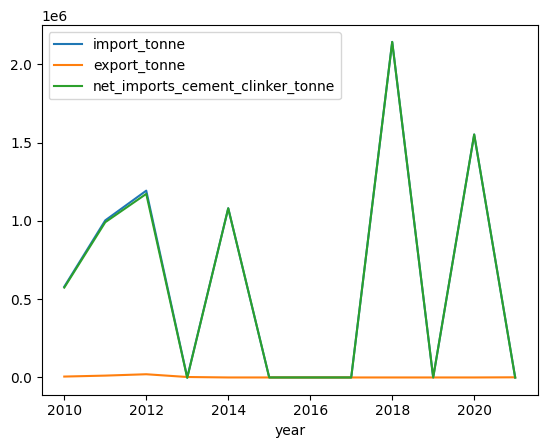

In [551]:
(
    df_clinker_trade[df_clinker_trade[field_iso3].isin(["CHL"])]
    .drop([field_iso3], axis = 1)
    .plot(x = field_year)
)


In [534]:
importlib.reload(ma)
importlib.reload(sa)

<module 'setup_analysis' from '/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/setup_analysis.py'>

In [491]:
tup = get_country_isos(
    df_wti,
    field_country,
    field_iso3
)

In [495]:
[x for x in tup[0][field_iso3].unique() if len(x) != 3]


['Egypt, Arab Rep.',
 'Korea, Rep.',
 'European Union',
 'Hong Kong, China',
 'Other Asia, nes',
 'Lao PDR',
 'Serbia, FR(Serbia/Montenegro)',
 'Congo, Rep.',
 'Iran, Islamic Rep.',
 'Fm Sudan',
 'Ethiopia(excludes Eritrea)',
 'Bahamas, The',
 'Occ.Pal.Terr']

In [512]:
pycountry.countries.search_fuzzy("Bahamas")

[Country(alpha_2='BS', alpha_3='BHS', flag='🇧🇸', name='Bahamas', numeric='044', official_name='Commonwealth of the Bahamas')]

In [367]:
#[x for x in dfc.columns if (x != field_iso3) and (len(set(dfc[x])) > 1)]
field_agg = "emission_mt_co2e_essd_other_industry_ch3f"
dfc_tmp = dfc[[field_iso3, field_agg]].groupby([field_iso3]).agg({field_iso3: "first", field_agg: "max"}).reset_index(drop = True).sort_values(by = [field_agg], ascending = False)
dfc_tmp



,iso_code3,emission_mt_co2e_essd_other_industry_ch3f
27,CAN,0.008990
155,TUR,0.000154
0,ABW,0.000000
107,MOZ,0.000000
109,MUS,0.000000
...,...,...
59,GHA,0.000000
60,GIN,0.000000
61,GMB,0.000000
62,GNB,0.000000


In [384]:
fields_targeted
[x for x in df_essd_calibration_targets.columns if x not in fields_targeted + [field_iso, field_year]]

['emission_mt_co2e_essd_cement_co2',
 'emission_mt_co2e_essd_chemicals_ch4',
 'emission_mt_co2e_essd_chemicals_co2',
 'emission_mt_co2e_essd_chemicals_n2o',
 'emission_mt_co2e_essd_metals_ch4',
 'emission_mt_co2e_essd_metals_co2',
 'emission_mt_co2e_essd_metals_n2o',
 'emission_mt_co2e_essd_other_industry_ch4',
 'emission_mt_co2e_essd_other_industry_co2',
 'emission_mt_co2e_essd_other_industry_n2o']

In [508]:
#[x for x in df_essd_calibration_targets.columns if x not in fields_targeted]
df_essd[df_essd[field_title_subsector].isin(essd_sectors_for_fgas_ippu)][[field_gas, field_title_subsector]].drop_duplicates().sort_values(
    by = [field_gas, field_title_subsector]
)








,gas,subsector_title
175339,c2f6,Chemicals
11680,c2f6,Metals
13884,c2f6,Other (industry)
156615,c2h3f3,Chemicals
1622,c2h3f3,Other (industry)
35963,c2hf5,Chemicals
1620,c2hf5,Other (industry)
183434,c3f8,Chemicals
13885,c3f8,Other (industry)
21821,c3h2f6,Other (industry)


<AxesSubplot: xlabel='year'>

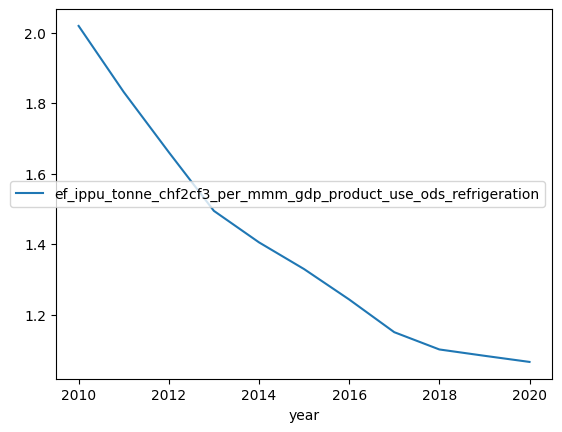

In [480]:
df_efs_out[
    #df_efs_out[field_year].isin([2015]) &
    df_efs_out[field_iso3].isin(["USA"])
][[field_year, "ef_ippu_tonne_chf2cf3_per_mmm_gdp_product_use_ods_refrigeration"]].plot(x = field_year)

In [516]:
ef_2015_a = float(df_efs_out[
    df_efs_out[field_year].isin([2015]) &
    df_efs_out[field_iso3].isin(["BRA"])
]["ef_ippu_tonne_chf2cf3_per_mmm_gdp_product_use_ods_other"].iloc[0])

ef_2015_b = float(df_efs_out[
    df_efs_out[field_year].isin([2015]) &
    df_efs_out[field_iso3].isin(["BRA"])
]["ef_ippu_tonne_chf2cf3_per_mmm_gdp_product_use_ods_refrigeration"].iloc[0])

prod = float(df_inputs[
    df_inputs[field_year].isin([2015]) &
    df_inputs[field_iso3].isin(["BRA"])
]["gdp_mmm_usd"].iloc[0])

emit = prod*(ef_2015_a + ef_2015_b)*sa.model_attributes.get_gwp("chf2cf3")/1000000



calib = float(df_essd_calibration_targets[
    df_essd_calibration_targets[field_year].isin([2015]) &
    df_essd_calibration_targets[field_iso].isin(["BRA"])
]["emission_mt_co2e_essd_other_industry_chf2cf3"].iloc[0])



emit, calib

(6.093530999999999, 6.093531)

In [517]:
ef_2020 = 1.862774e-07
prod = float(df_inputs[
    df_inputs[field_year].isin([2020]) &
    df_inputs[field_iso3].isin(["MEX"])
]["prodinit_ippu_metals_tonne"].iloc[0])


prod*ef_2020*sa.model_attributes.get_gwp("sf6")

119349.93256708623

In [518]:

df_essd_calibration_targets[
    df_essd_calibration_targets[field_year].isin([2020]) &
    df_essd_calibration_targets[field_iso].isin(["MEX"])
]["emission_mt_co2e_essd_metals_sf6"]

6372    0.11935
Name: emission_mt_co2e_essd_metals_sf6, dtype: float64

In [435]:
df_efs_out[
    (df_efs_out["ef_ippu_tonne_sf6_per_tonne_production_metals"] > 0) &
    df_efs_out[field_iso3].isin([x.upper() for x in attr_region.table["iso_alpha_3"]])
].sort_values(by = ["ef_ippu_tonne_sf6_per_tonne_production_metals"])



,iso_code3,year,ef_ippu_tonne_sf6_per_tonne_production_metals,ef_ippu_tonne_sf6_per_tonne_production_chemicals,ef_ippu_tonne_sf6_per_tonne_production_electronics,ef_ippu_tonne_sf6_per_mmm_gdp_other_product_manufacturing,ef_ippu_tonne_chf3_per_tonne_production_chemicals,ef_ippu_tonne_chf3_per_tonne_production_electronics,ef_ippu_tonne_chf3_per_mmm_gdp_product_use_ods_other,ef_ippu_tonne_chf3_per_mmm_gdp_product_use_ods_refrigeration,...,ef_ippu_tonne_c2hf5_per_mmm_gdp_product_use_ods_refrigeration,ef_ippu_tonne_chf2cf3_per_mmm_gdp_product_use_ods_other,ef_ippu_tonne_chf2cf3_per_mmm_gdp_product_use_ods_refrigeration,ef_ippu_tonne_c2h3f3_per_mmm_gdp_product_use_ods_refrigeration,ef_ippu_tonne_ch3chf2_per_mmm_gdp_product_use_ods_other,ef_ippu_tonne_ch3chf2_per_mmm_gdp_product_use_ods_refrigeration,ef_ippu_tonne_c2f6_per_tonne_production_metals,ef_ippu_tonne_c2f6_per_tonne_production_electronics,ef_ippu_tonne_c2f6_per_mmm_gdp_product_use_ods_other,ef_ippu_tonne_c3f8_per_tonne_production_electronics
1114,MEX,2013,1.140102e-07,0.0,3.475589e-08,0.000284,0.000034,0.0,0.0,0.0,...,0.121261,1.209975,1.209975,0.206612,0.0,0.0,0.0,0.0,0.0,0.0
1112,MEX,2011,1.159194e-07,0.0,3.799313e-08,0.000307,0.000061,0.0,0.0,0.0,...,0.090369,1.184683,1.184683,0.175799,0.0,0.0,0.0,0.0,0.0,0.0
1113,MEX,2012,1.169552e-07,0.0,3.726859e-08,0.000295,0.000037,0.0,0.0,0.0,...,0.106988,1.196187,1.196187,0.190705,0.0,0.0,0.0,0.0,0.0,0.0
1111,MEX,2010,1.202744e-07,0.0,3.777875e-08,0.000321,0.000068,0.0,0.0,0.0,...,0.078521,1.149371,1.149371,0.159338,0.0,0.0,0.0,0.0,0.0,0.0
1115,MEX,2014,1.230552e-07,0.0,3.538091e-08,0.000275,0.000043,0.0,0.0,0.0,...,0.135648,1.237441,1.237441,0.223631,0.0,0.0,0.0,0.0,0.0,0.0
1116,MEX,2015,1.403871e-07,0.0,3.663322e-08,0.000264,0.000025,0.0,0.0,0.0,...,0.151730,1.238890,1.238890,0.241935,0.0,0.0,0.0,0.0,0.0,0.0
1117,MEX,2016,1.572880e-07,0.0,3.982696e-08,0.000265,0.000028,0.0,0.0,0.0,...,0.164771,1.314440,1.314440,0.253810,0.0,0.0,0.0,0.0,0.0,0.0
1119,MEX,2018,1.608518e-07,0.0,3.606106e-08,0.000265,0.000033,0.0,0.0,0.0,...,0.200561,1.476296,1.476296,0.287322,0.0,0.0,0.0,0.0,0.0,0.0
1118,MEX,2017,1.617559e-07,0.0,3.638876e-08,0.000266,0.000032,0.0,0.0,0.0,...,0.181829,1.393476,1.393476,0.270041,0.0,0.0,0.0,0.0,0.0,0.0
1120,MEX,2019,1.636647e-07,0.0,3.455479e-08,0.000265,0.000032,0.0,0.0,0.0,...,0.199282,1.466879,1.466879,0.285490,0.0,0.0,0.0,0.0,0.0,0.0


In [410]:
df_calibration_data[df_calibration_data[field_calibration_target] > 0][[field_calibration_target]]


,emission_mt_co2e_essd_other_industry_c4f10
44,0.000060
45,0.000060
46,0.000060
47,0.000060
48,0.000060
...,...
1590,0.001065
1591,0.001065
1592,0.001065
1593,0.001078


In [310]:
modvar = model_ippu.modvar_ippu_emissions_ppu_hfc23
subsec = sa.model_attributes.get_variable_subsector(modvar)
sa.model_attributes.build_varlist(
    subsec,
    modvar
)

['emission_co2e_chf3_ippu_production_and_product_use_chemicals',
 'emission_co2e_chf3_ippu_production_and_product_use_electronics',
 'emission_co2e_chf3_ippu_production_and_product_use_product_use_ods_other',
 'emission_co2e_chf3_ippu_production_and_product_use_product_use_ods_refrigeration']

In [ ]:
# GET FACTORS FOR `product_use_ods_other`

cat = "product_use_ods_other"



In [351]:
?sa.model_attributes.build_varlist

Signature:
sa.model_attributes.build_varlist(
    subsector: str,
    variable_subsec: str = None,
    restrict_to_category_values: list = None,
    dict_force_override_vrp_vvs_cats: dict = None,
    variable_type: str = None,
) -> list
Docstring:
Build a list of fields (complete variable schema from a data frame) 
    based on the subsector and variable name.

Function Arguments
------------------
- subsector: str, the subsector to build the variable list for.
- variable_subsec: default is None. If None, then builds varlist of all 
    variables required for this variable.

Keyword Arguments
-----------------
- dict_force_override_vrp_vvs_cats: dict_force_override_vrp_vvs_cats can 
    be set do a dictionary of the form

    {
        MODEL_VAR_NAME: [catval_a, catval_b, catval_c, ... ]
    }

    where catval_i are not all unique; this is useful for making a 
    variable that maps unique categories to a subset of non-unique 
    categories that represent proxies (e.g., buffalo -> ca

In [666]:
attr_region.table

,category_name,region,iso_alpha_3,description,hourly_capacity_factor_region,powerplant_data,io_data,fao_area_code
0,Argentina,argentina,arg,NaN,Southern,Yes,Yes,9
1,Bahamas,bahamas,bhs,NaN,Northern,No,No,12
2,Barbados,barbados,brb,NaN,Equatorial,No,No,14
3,Belize,belize,blz,NaN,Equatorial,No,No,23
4,Bolivia,bolivia,bol,NaN,Southern,Yes,Yes,19
5,Brazil,brazil,bra,NaN,Southern,Yes,Yes,21
6,Chile,chile,chl,NaN,Southern,Yes,Yes,40
7,Colombia,colombia,col,NaN,Equatorial,Yes,Yes,44
8,Costa Rica,costa_rica,cri,NaN,Equatorial,Yes,Yes,48
9,Dominican Republic,dominican_republic,dom,NaN,Northern,Yes,Yes,56


26